# 📊 Análisis de Componentes Principales (PCA) del Índice Delictivo

Este análisis aplica la reducción de dimensionalidad mediante PCA a las tasas de incidencia delictiva por colonia para crear 8 índices de riesgo (Componentes Principales) que explican el patrón delictivo en Hermosillo.

---

## Contenido

1.  Carga de Datos y Configuración
2.  Agregación de Tasas por Colonia
3.  Estandarización y Preparación
4.  Ejecución de PCA Inicial y Gráfico de Codo
5.  Aplicación de PCA Final (k=8)
6.  Análisis e Interpretación de Cargas (Resultados)

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from difflib import get_close_matches # Útil para la validación de columnas
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIGURACIÓN DE PARÁMETROS ---
N_COMPONENTES_FINALES = 8
N_TOP_INCIDENTES = 5
UMBRAL_VARIANZA = 0.80

# --- Rutas (Ajusta la ruta raíz a tu entorno de libreta) ---
# Si ejecutas la libreta desde la raíz del proyecto, usa Path.cwd()
PROJECT_ROOT = Path.cwd().parent 

RUTA_REPORTES = PROJECT_ROOT / "data" / "interim" / "reportes_de_incidentes_procesados_2018_2025.csv"
RUTA_DEMOGRAFIA = PROJECT_ROOT / "data" / "processed" / "demografia_limpio.csv"
RUTA_OUTPUT_FINAL = PROJECT_ROOT / "data" / "processed" / "unificado"

print("✅ Librerías y Rutas de Archivos configuradas.")

✅ Librerías y Rutas de Archivos configuradas.


In [8]:
# --- Función de Validación Inteligente de Columnas ---
def validar_columnas(df, columnas_esperadas, umbral_similitud=0.8):
    """Valida si las columnas existen o encuentra la coincidencia más cercana."""
    columnas_actuales = df.columns.tolist()
    columnas_corregidas = {}
    for esperada in columnas_esperadas:
        if esperada in columnas_actuales:
            columnas_corregidas[esperada] = esperada
        else:
            coincidencias = get_close_matches(esperada, columnas_actuales, n=1, cutoff=umbral_similitud)
            if coincidencias:
                print(f"⚠️ La columna '{esperada}' no se encontró. Usando '{coincidencias[0]}' como reemplazo.")
                columnas_corregidas[esperada] = coincidencias[0]
            else:
                raise ValueError(f"❌ No se encontró ninguna columna similar a '{esperada}' en el DataFrame.")
    return columnas_corregidas

print("✅ Funciones auxiliares definidas.")

✅ Funciones auxiliares definidas.


In [9]:
print("--- Iniciando Preparación de Datos ---")

try:
    df_reportes = pd.read_csv(RUTA_REPORTES)
    df_demografia = pd.read_csv(RUTA_DEMOGRAFIA)
    print(f"DEBUG: Reportes: {df_reportes.shape[0]} filas. Demografía: {df_demografia.shape[0]} filas.")

    # A. Validación de columnas
    col_map_reportes = validar_columnas(df_reportes, ['COLONIA', 'TIPO DE INCIDENTE'])
    COLONIA_NORMALIZADA_COL = col_map_reportes['COLONIA']
    INCIDENTE_ESTANDARIZADO_COL = col_map_reportes['TIPO DE INCIDENTE']

    # B. Agregación de Frecuencias y Pivotaje
    print("\n[PASO 1] Creando matriz de tasas de incidencia...")
    df_conteo = (
        df_reportes.groupby([COLONIA_NORMALIZADA_COL, INCIDENTE_ESTANDARIZADO_COL])
        .size()
        .reset_index(name='Conteo')
    )
    df_matriz_incidentes = df_conteo.pivot_table(
        index=COLONIA_NORMALIZADA_COL, columns=INCIDENTE_ESTANDARIZADO_COL, values='Conteo', fill_value=0
    )
    columnas_incidentes = df_matriz_incidentes.columns.tolist()

    # C. Cálculo de Tasas (Normalización por Población)
    col_map_demo = validar_columnas(df_demografia, ['nom_col', 'poblacion_total'])
    df_demografia = df_demografia.rename(columns={col_map_demo['nom_col']: COLONIA_NORMALIZADA_COL, col_map_demo['poblacion_total']: 'Poblacion_2020'})

    df_matriz_final = df_matriz_incidentes.reset_index().merge(
        df_demografia[[COLONIA_NORMALIZADA_COL, 'Poblacion_2020']], on=COLONIA_NORMALIZADA_COL, how='left'
    )

    media_poblacion = df_demografia['Poblacion_2020'].mean()
    df_matriz_final['Poblacion_2020'] = df_matriz_final['Poblacion_2020'].fillna(media_poblacion).astype(int)

    periodo_años = 7.75 # Asumiendo el periodo de 2018 a 2025 (~7.75 años)
    for col in columnas_incidentes:
        # Cálculo de la tasa (Incidente / (Población * Años)) * 100k
        df_matriz_final[col] = (df_matriz_final[col] / (df_matriz_final['Poblacion_2020'] * periodo_años)) * 100000

    X = df_matriz_final[columnas_incidentes].values

    # D. Estandarización de Datos
    print("[PASO 2] Estandarizando y preparando matriz para PCA...")
    X = np.where(np.isfinite(X), X, np.nan)
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"✅ Matriz lista para PCA: {X_scaled.shape[0]} colonias x {X_scaled.shape[1]} incidentes/features.")

except Exception as e:
    print(f"Error fatal durante la preparación de datos: {e}")
    sys.exit(1)

--- Iniciando Preparación de Datos ---
DEBUG: Reportes: 2297074 filas. Demografía: 660 filas.

[PASO 1] Creando matriz de tasas de incidencia...
[PASO 2] Estandarizando y preparando matriz para PCA...
✅ Matriz lista para PCA: 2296 colonias x 198 incidentes/features.



[PASO 3] Ejecutando PCA inicial para determinar 'k'...

Resultado del Scree Plot:
 - El 80% de la varianza requiere 8 Componentes Principales.
 - Usaremos la configuración final de k=8 Componentes Principales.


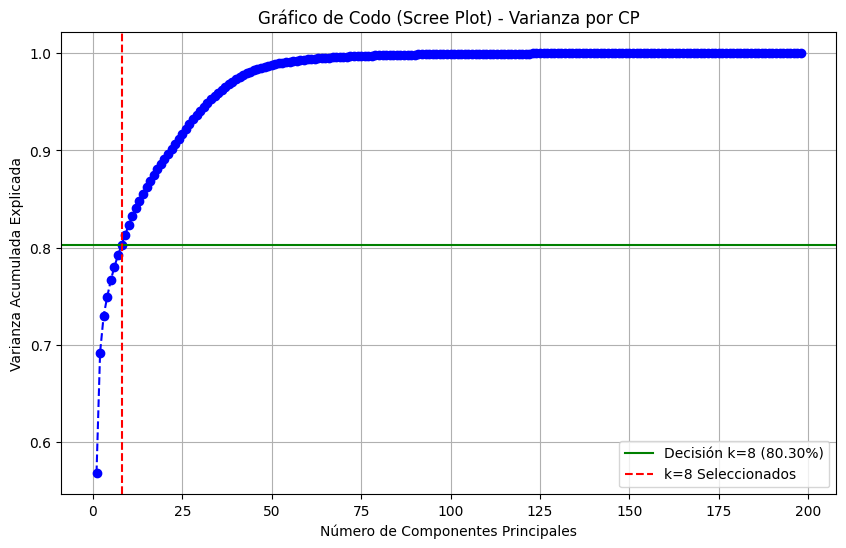

In [11]:
print("\n[PASO 3] Ejecutando PCA inicial para determinar 'k'...")
pca_inicial = PCA(n_components=None)
pca_inicial.fit(X_scaled)

varianza_explicada = pca_inicial.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Determinar el número de CPs para el umbral configurado (80%)
try:
    n_componentes_optimo = np.where(varianza_acumulada >= UMBRAL_VARIANZA)[0][0] + 1
except IndexError:
    n_componentes_optimo = len(varianza_explicada)
    print("🚨 Advertencia: El umbral de varianza no se alcanzó con todos los componentes.")

# --- Generación del Gráfico de Codo (Scree Plot) ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_acumulada, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title(f'Gráfico de Codo (Scree Plot) - Varianza por CP')
plt.grid(True)

# Resaltar la decisión final de k=8 (80% de varianza retenida)
print(f"\nResultado del Scree Plot:")
print(f" - El {UMBRAL_VARIANZA*100:.0f}% de la varianza requiere {n_componentes_optimo} Componentes Principales.")
print(f" - Usaremos la configuración final de k={N_COMPONENTES_FINALES} Componentes Principales.")

# Líneas de referencia para la decisión final (k=8)
varianza_k8 = varianza_acumulada[N_COMPONENTES_FINALES-1]
plt.axhline(y=varianza_k8, color='g', linestyle='-', label=f'Decisión k={N_COMPONENTES_FINALES} ({varianza_k8*100:.2f}%)')
plt.axvline(x=N_COMPONENTES_FINALES, color='r', linestyle='--', label=f'k={N_COMPONENTES_FINALES} Seleccionados')
plt.legend()
plt.show()

In [12]:
k = N_COMPONENTES_FINALES
print(f"\n[PASO 4] Aplicando PCA final con k={k} y transformando datos...")

# A. Aplicación del PCA con k=8
pca_final = PCA(n_components=k)
X_pca = pca_final.fit_transform(X_scaled)

# B. Creación del DataFrame de Puntuaciones (Los Índices)
nombres_cp = [f'CP{i+1}' for i in range(k)]
df_pca_puntuaciones = pd.DataFrame(data=X_pca, columns=nombres_cp)
df_pca_puntuaciones.insert(0, COLONIA_NORMALIZADA_COL, df_matriz_final[COLONIA_NORMALIZADA_COL].values)

# C. Creación del DataFrame de Cargas (La Interpretación)
df_cargas = pd.DataFrame(pca_final.components_, columns=columnas_incidentes, index=nombres_cp)

# D. Guardado de Resultados
RUTA_OUTPUT_FINAL.mkdir(parents=True, exist_ok=True)
try:
    df_pca_puntuaciones.to_csv(RUTA_OUTPUT_FINAL / 'colonias_pca_puntuaciones.csv', index=False)
    df_cargas.to_csv(RUTA_OUTPUT_FINAL / 'colonias_pca_cargas_componentes.csv')
    print(f"✅ Archivos guardados en: {RUTA_OUTPUT_FINAL}")
except Exception as e:
    print(f"\n❌ ERROR AL GUARDAR ARCHIVOS: {e}")
    print("Verifica permisos o si los archivos están abiertos.")


[PASO 4] Aplicando PCA final con k=8 y transformando datos...
✅ Archivos guardados en: c:\Users\cazar\Downloads\indice-delictivo-hermosillo\data\processed\unificado


In [14]:
print("\n[PASO 5] Análisis de Cargas (Interpretación de los 8 Índices)...")

# 1. Iterar sobre todos los Componentes Principales
for cp_nombre in df_cargas.index:

    print(f"\n====================================================================")
    print(f"  🔍 ANALIZANDO {cp_nombre} (Varianza: {pca_final.explained_variance_ratio_[int(cp_nombre[2:])-1]*100:.2f}%)")
    print(f"====================================================================")

    # Obtener las cargas de ese CP y ordenarlas
    cargas_ordenadas = df_cargas.loc[cp_nombre].sort_values(ascending=False)

    # a. Cargas Positivas (Incidentes que impulsan este índice)
    top_cargas_positivas = cargas_ordenadas.head(N_TOP_INCIDENTES)
    print(f"✨ Top {N_TOP_INCIDENTES} Incidentes Positivos (Definición del Eje):")
    display(top_cargas_positivas.to_frame(name='Carga'))

    # b. Cargas Negativas (Incidentes que son inversos o están ausentes)
    bottom_cargas_negativas = cargas_ordenadas.tail(N_TOP_INCIDENTES)
    print(f"\n📉 Top {N_TOP_INCIDENTES} Incidentes Negativos (Contrastes):")
    display(bottom_cargas_negativas.to_frame(name='Carga'))

print("\n--- ✅ PROCESO PCA Y ANÁLISIS COMPLETADO ---")


[PASO 5] Análisis de Cargas (Interpretación de los 8 Índices)...

  🔍 ANALIZANDO CP1 (Varianza: 56.82%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
OTROS INCIDENTES MÉDICOS TRAUMÁTICOS,0.094034
PERSONA INCONSCIENTE/URGENCIA NEUROLÓGICA,0.094022
ABUSO DE AUTORIDAD,0.093657
DAÑO A PROPIEDAD AJENA,0.093653
ACCIDENTE DE VEHÍCULO AUTOMOTOR CON LESIONADOS,0.093570



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
FUGA DE REOS,0.000294
ACOSO,0.000174
ROBO A EMPRESA DE TRASLADO DE VALORES SIN VIOLENCIA,0.000161
ROBO A EMPRESA DE TRASLADO DE VALORES CON VIOLENCIA,0.000100
POSESIÓN DE ESPECIES DE FLORA Y FAUNA SUJETAS A PROTECCIÓN,-0.000091



  🔍 ANALIZANDO CP2 (Varianza: 12.41%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
DETECCIÓN DE VEHÍCULO CON REPORTE DE INCIDENTE PREVIO,0.168244
EXTORSIÓN TELEFÓNICA,0.168089
CONCENTRACIÓN PACÍFICA DE PERSONAS,0.166385
ALTERACIÓN DEL ORDEN PÚBLICO POR PERSONA ALCOHOLIZADA,0.165271
DAÑOS A PROPIEDAD AJENA,0.164972



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
FALLECIDO DE CAUSA TRAUMÁTICA,-0.110139
INCENDIO DE FÁBRICA O INDUSTRIA,-0.110308
AERONAVE SOSPECHOSA,-0.110504
AMPUTACIÓN,-0.110564
ROBO DE COMBUSTIBLE O TOMA CLANDESTINA DE DUCTOS,-0.110632



  🔍 ANALIZANDO CP3 (Varianza: 3.79%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
MORDEDURA DE ANIMAL,0.306638
CORRUPCIÓN DE MENORES,0.272526
VIOLACIÓN,0.242204
ROBO A TRANSPORTISTA SIN VIOLENCIA,0.233466
VEHÍCULO EN HUIDA,0.231439



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
PERSONA ATRAPADA,-0.044580
ROBO A ESCUELA SIN VIOLENCIA,-0.044824
OTROS RESCATES,-0.045278
CAÍDA DE POSTE,-0.046841
TALA ILEGAL,-0.048347



  🔍 ANALIZANDO CP4 (Varianza: 1.95%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
CAÍDA DE BARDA,0.382187
VIOLACIÓN,0.315786
VEHÍCULO EN HUIDA,0.311496
ROBO A TRANSPORTISTA SIN VIOLENCIA,0.292075
CORRUPCIÓN DE MENORES,0.196869



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
ROBO DE ANIMALES-MASCOTAS,-0.151349
AHOGAMIENTO,-0.158065
EPIDEMIAS,-0.172274
ROBO DE GANADO,-0.176664
RESTOS HUMANOS,-0.230725



  🔍 ANALIZANDO CP5 (Varianza: 1.69%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
INCENDIO EN ESCUELA,0.370623
DERRUMBES,0.360529
INFARTO/URGENCIA CARDIOLÓGICA,0.177198
ROBO DE PLACA,0.149292
RUIDO EXCESIVO,0.149138



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
ACCIDENTE DE MOTOCICLETA CON FALLECIDO,-0.200292
ROBO DE GANADO,-0.232889
ROBO DE ANIMALES-MASCOTAS,-0.261494
RESTOS HUMANOS,-0.268521
EPIDEMIAS,-0.304717



  🔍 ANALIZANDO CP6 (Varianza: 1.38%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
DERRUMBES,0.352431
INCENDIO EN ESCUELA,0.333456
EPIDEMIAS,0.222795
ROBO DE ANIMALES-MASCOTAS,0.210273
RESTOS HUMANOS,0.196646



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
RUIDO EXCESIVO,-0.131658
VIOLENCIA FAMILIAR,-0.132083
ROBO A CASA HABITACIÓN SIN VIOLENCIA,-0.151572
PERSONA LOCALIZADA,-0.185180
INTOXICACIÓN ETÍLICA,-0.215774



  🔍 ANALIZANDO CP7 (Varianza: 1.17%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
EXPLOTACIÓN DE MENORES,0.517787
QUEMA URBANA,0.489343
OTROS ACTOS RELACIONADOS CON OTROS BIENES JURÍDICOS,0.219800
"VENTA CLANDESTINA DE PIROTECNIA, COHETES O FUEGOS ARTIFICIALES",0.197110
FRAUDE,0.196940



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
DERRUMBES,-0.079123
ROBO A CASA HABITACIÓN SIN VIOLENCIA,-0.095183
ESTUPRO,-0.097655
TRABAJO DE PARTO,-0.131113
AMENAZA DE ABORTO,-0.158919



  🔍 ANALIZANDO CP8 (Varianza: 1.08%)
✨ Top 5 Incidentes Positivos (Definición del Eje):


,Carga
ENFRENTAMIENTO DE GRUPOS ARMADOS,0.531123
INCENDIO DE RESIDUOS/ BASURA,0.513380
SUSTRACCIÓN DE MENORES,0.136010
ROBO A CASA HABITACIÓN SIN VIOLENCIA,0.132190
ACCIDENTE DE VEHÍCULO DE PASAJEROS CON LESIONADOS,0.119013



📉 Top 5 Incidentes Negativos (Contrastes):


,Carga
TRABAJO DE PARTO,-0.093645
INTOXICACIÓN ETÍLICA,-0.129597
HALLAZGO DE ARMA,-0.237121
CAÍDA DE ANUNCIO O ESPECTACULAR,-0.247485
AMENAZA DE BOMBA,-0.319979



--- ✅ PROCESO PCA Y ANÁLISIS COMPLETADO ---


In [ ]:
# Definición de los 8 Componentes Principales (CPs)
pca_nombres_interpretados = {
    'CP1': 'Índice de Demanda de Emergencia General',
    'CP2': 'Índice de Desorden Público y Alertas',
    'CP3': 'Índice de Riesgo Social y Vulnerabilidad',
    'CP4': 'Índice de Delitos Sexuales y Riesgo Estructural',
    'CP5': 'Índice de Riesgo Físico y Fallas de Infraestructura',
    'CP6': 'Índice de Riesgo Ambiental y Hallazgos',
    'CP7': 'Índice de Delitos de Explotación y Riesgo Regulatorio',
    'CP8': 'Índice de Violencia Organizada y Contaminación'
}

print("✅ Diccionario de nombres interpretados creado.")

# EJEMPLO DE USO (Asumiendo que colonias_pca_puntuaciones ya fue generado):
# # 1. Renombrar las columnas de CP1 a CP8 con sus nombres descriptivos
# colonias_pca_puntuaciones_nombrado = colonias_pca_puntuaciones.rename(columns=pca_nombres_interpretados)

# # 2. Mostrar un ejemplo
# print("\nEjemplo de las nuevas columnas de puntuación:")
# print(colonias_pca_puntuaciones_nombrado.head())

✅ Diccionario de nombres interpretados creado.
